In [1]:
%matplotlib inline

import xarray as xr
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, save
from bokeh.io import reset_output
import bokeh
import sys
import multiprocessing as mp
from collections import OrderedDict
import cartopy.crs as ccrs

from tonic.io import read_configobj
import timeit

from analysis_utils import (
    rmse, find_global_param_value, determine_tile_frac, get_soil_depth,
    load_nc_file, setup_output_dirs, calc_sm_runoff_corrcoef,
    to_netcdf_state_file_compress, calculate_rmse, calculate_pbias,
    add_gridlines)

In [2]:
# ========================================================== #
# Command line arguments
# ========================================================== #
# --- Load in config file --- #
cfg = read_configobj('/civil/hydro/ymao/data_assim/tools/plot_analyze_results/' \
                     'cfg/20170611.ArkRed.sm1_5.sm2_5.R_1.N32.Maurer_param.synthetic/' \
                     'plot.synth.random1.cfg')

In [3]:
# ========================================================== #
# Parameter setting
# ========================================================== #
# --- Input directory and files --- #
# gen_synthetic results
gen_synth_basedir = cfg['SYNTHETIC']['gen_synth_basedir']
truth_nc_filename = cfg['SYNTHETIC']['truth_nc_filename']
synth_meas_nc_filename = cfg['SYNTHETIC']['synth_meas_nc_filename']

# openloop
openloop_basedir = cfg['SYNTHETIC']['openloop_basedir']

# Time period
start_time = pd.to_datetime(cfg['SYNTHETIC']['start_time'])
end_time = pd.to_datetime(cfg['SYNTHETIC']['end_time'])
start_year = start_time.year
end_year = end_time.year

# VIC global file template (for extracting param file and snow_band)
vic_global_txt = cfg['SYNTHETIC']['vic_global_txt']

# Forcings (for all basepaths, 'YYYY.nc' will be appended)
orig_force_basepath = cfg['SYNTHETIC']['orig_force_basepath']
truth_force_basepath = cfg['SYNTHETIC']['truth_force_basepath']
# ens_force_basedir/ens_<i>/force.<YYYY>.nc, where <i> = 1, 2, ..., N
ens_force_basedir = cfg['SYNTHETIC']['ens_force_basedir']

# VIC parameter netCDF file
vic_param_nc = cfg['SYNTHETIC']['vic_param_nc']

# Domain netCDF file
domain_nc = cfg['SYNTHETIC']['domain_nc']

# --- Measurement times --- #
meas_times = pd.date_range(
    cfg['SYNTHETIC']['meas_start_time'],
    cfg['SYNTHETIC']['meas_end_time'],
    freq=cfg['SYNTHETIC']['freq'])

# --- Plot time period --- #
plot_start_time = pd.to_datetime(cfg['SYNTHETIC']['plot_start_time'])
plot_end_time = pd.to_datetime(cfg['SYNTHETIC']['plot_end_time'])
plot_start_year = plot_start_time.year
plot_end_year = plot_end_time.year

# --- Output --- #
output_rootdir = cfg['OUTPUT']['output_dir']

In [4]:
# ========================================================== #
# Setup output data dir
# ========================================================== #
output_data_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['data'])['data']

output_maps_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['maps'])['maps']

output_ts_dir = setup_output_dirs(
        output_rootdir,
        mkdirs=['time_series'])['time_series']

In [5]:
# ========================================================== #
# Load data
# ========================================================== #
print('Loading data...')

# --- Domain --- #
da_domain = xr.open_dataset(domain_nc)['mask']

# --- Tile fraction --- #
da_tile_frac = determine_tile_frac(vic_global_txt)  # [veg_class, snow_band, lat, lon]

# --- Openloop --- #
print('\tOpenloop history...')
openloop_hist_nc = os.path.join(
    openloop_basedir,
    'history',
    'history.openloop.{}-{:05d}.nc'.format(
        start_time.strftime('%Y-%m-%d'),
        start_time.hour*3600+start_time.second))
ds_openloop_hist = xr.open_dataset(openloop_hist_nc)
print('\tOpenloop states...')
openloop_state_nc = os.path.join(
    openloop_basedir,
    'states',
    'openloop_state_cellAvg.{}_{}.nc'.format(
        meas_times[0].strftime('%Y%m%d'),
        meas_times[-1].strftime('%Y%m%d')))
ds_openloop_states = xr.open_dataset(openloop_state_nc)

# --- Truth --- #
print('\tTruth history...')
ds_truth_hist = xr.open_dataset(os.path.join(
        gen_synth_basedir, 'truth',
        'history', truth_nc_filename))
print('\tTruth states...')
truth_state_nc = os.path.join(
    gen_synth_basedir,
    'truth',
    'states',
    'truth_state_cellAvg.{}_{}.nc'.format(
        meas_times[0].strftime('%Y%m%d'),
        meas_times[-1].strftime('%Y%m%d')))
ds_truth_states = xr.open_dataset(truth_state_nc)

# --- Measurement --- #
print('\tMeasurements...')
da_meas = xr.open_dataset(os.path.join(
    gen_synth_basedir, 'synthetic_meas', synth_meas_nc_filename))['simulated_surface_sm']

Loading data...
	Openloop history...
	Openloop states...
	Truth history...
	Truth states...
	Measurements...


In [12]:
# --- Forcing, openloop --- #
ds_openloop_prec_nc = '{}prec.{}_{}.nc'.format(orig_force_basepath, start_year, end_year)
if not os.path.isfile(ds_openloop_prec_nc):  # if RMSE is not already calculated
    # Load all years of forcing data
    list_da = []
    for year in range(start_year, end_year+1):
        force_nc = '{}{}.nc'.format(orig_force_basepath, year)
        list_da.append(xr.open_dataset(force_nc)['PREC'])
    da_openloop_prec = xr.concat(list_da, dim='time')
    # Save to netCDF file
    ds_openloop_prec = xr.Dataset({'PREC': da_openloop_prec})
    ds_openloop_prec.to_netcdf(ds_openloop_prec_nc, format='NETCDF4_CLASSIC')
else:
    da_openloop_prec = xr.open_dataset(ds_openloop_prec_nc)['PREC']

In [43]:
# --- Perfect-all-state, orig. forcing --- #
print('\ttruthStates_origP...')
ds_truthStateOrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_states_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

# --- Perfect-SM1, orig. forcing --- #
print('\ttruthSM1_origP...')
ds_truthSM1OrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_sm1_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

# --- Perfect-SM2, orig. forcing --- #
print('\ttruthSM2_origP...')
ds_truthSM2OrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_sm2_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

# --- Perfect-SM3, orig. forcing --- #
print('\ttruthSM3_origP...')
ds_truthSM3OrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_sm3_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

# --- Perfect-SWE, orig. forcing --- #
print('\ttruthSWE_origP...')
ds_truthSWEOrigP_hist = xr.open_dataset(os.path.join(
    gen_synth_basedir,
    'test.truth_swe_orig_forcing',
    'history',
    'history.concat.{}_{}.nc'.format(
        start_time.strftime('%Y%m%d'),
        end_time.strftime('%Y%m%d'))))

	truthStates_origP...
	truthSM1_origP...
	truthSM2_origP...
	truthSM3_origP...
	truthSWE_origP...


In [44]:
# ======================================================== #
# Extract shared coordinates
# ======================================================== #
lat_coord = da_domain['lat']
lon_coord = da_domain['lon']

In [45]:
# ======================================================== #
# Extract soil layer depths
# ======================================================== #
da_soil_depth = get_soil_depth(vic_param_nc)  # [nlayer, lat, lon]
depth_sm1 = da_soil_depth.sel(nlayer=0)  # [lat, lon]
depth_sm2 = da_soil_depth.sel(nlayer=1)  # [lat, lon]
depth_sm3 = da_soil_depth.sel(nlayer=2)  # [lat, lon]

In [ ]:
# ======================================================== #
# Calculate RMSE(SM_openloop)
# ======================================================== #
print('Calculating RMSE(SM_openloop)')
# === sm1 === #
print('\tsm1')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_sm1.nc')
da_rmse_openloop_sm1 = calculate_rmse(
    out_nc, ds_truth_states, ds_openloop_states,
    var='sm1', depth_sm=depth_sm1)
# === sm2 === #
print('\tsm2')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_sm2.nc')
da_rmse_openloop_sm2 = calculate_rmse(
    out_nc, ds_truth_states, ds_openloop_states,
    var='sm2', depth_sm=depth_sm2)
# === sm3 === #
print('\tsm3')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_sm3.nc')
da_rmse_openloop_sm3 = calculate_rmse(
    out_nc, ds_truth_states, ds_openloop_states,
    var='sm3', depth_sm=depth_sm3)
# === SWE === #
print('\tSWE')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_swe.nc')
da_rmse_openloop_swe = calculate_rmse(
    out_nc, ds_truth_states, ds_openloop_states,
    var='swe')

In [ ]:
# ======================================================== #
# Calculate RMSE(runoff_openloop) - daily
# ======================================================== #
print('Calculating RMSE(runoff_openloop) - daily')
# === Surface runoff === #
print('\tsurface runoff')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_dailyRunoff.nc')
da_rmse_openloop_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_openloop_hist,
    var='runoff_daily')
# === Baseflow === #
print('\tbaseflow')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_dailyBaseflow.nc')
da_rmse_openloop_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_openloop_hist,
    var='baseflow_daily')
# === Total runoff === #
print('\ttotal runoff')
out_nc = os.path.join(output_data_dir, 'rmse_openloop_dailyTotrunoff.nc')
da_rmse_openloop_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_openloop_hist,
    var='totrunoff_daily')

In [ ]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthState_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthState_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthState_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthStateOrigP_dailyRunoff.nc')
da_rmse_truthStateOrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthStateOrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthStateOrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthStateOrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthState_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthStateOrigP_dailyBaseflow.nc')
da_rmse_truthStateOrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthStateOrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthStateOrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthStateOrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100

# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthState_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthStateOrigP_dailyTotrunoff.nc')
da_rmse_truthStateOrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthStateOrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthStateOrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthStateOrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

In [ ]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSM1_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSM1_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthSM1_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM1OrigP_dailyRunoff.nc')
da_rmse_truthSM1OrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM1OrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM1OrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthSM1OrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthSM1_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM1OrigP_dailyBaseflow.nc')
da_rmse_truthSM1OrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM1OrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM1OrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthSM1OrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100

# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSM1_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM1OrigP_dailyTotrunoff.nc')
da_rmse_truthSM1OrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM1OrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM1OrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthSM1OrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

In [ ]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSM2_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSM2_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthSM2_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM2OrigP_dailyRunoff.nc')
da_rmse_truthSM2OrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM2OrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM2OrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthSM2OrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthSM2_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM2OrigP_dailyBaseflow.nc')
da_rmse_truthSM2OrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM2OrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM2OrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthSM2OrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100
    
# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSM2_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM2OrigP_dailyTotrunoff.nc')
da_rmse_truthSM2OrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM2OrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM2OrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthSM2OrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

In [ ]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSM3_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSM3_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthSM3_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM3OrigP_dailyRunoff.nc')
da_rmse_truthSM3OrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM3OrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM3OrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthSM3OrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthSM3_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM3OrigP_dailyBaseflow.nc')
da_rmse_truthSM3OrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM3OrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM3OrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthSM3OrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100
    
# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSM3_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSM3OrigP_dailyTotrunoff.nc')
da_rmse_truthSM3OrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSM3OrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSM3OrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthSM3OrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

In [ ]:
# ======================================================== #
# Calculate PIMPROVE(runoff_truthSWE_origP, RMSE) - daily
# ======================================================== #
print('Calculating PIMPROVE(runoff_truthSWE_origP, RMSE) - daily')

# === Surface runoff === #
print('\tsurface runoff')
# --- Calculate RMSE of truthWE12_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSWEOrigP_dailyRunoff.nc')
da_rmse_truthSWEOrigP_dailyRunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSWEOrigP_hist,
    var='runoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSWEOrigP_dailyRunoff_rmse = \
    (1 - da_rmse_truthSWEOrigP_dailyRunoff / da_rmse_openloop_dailyRunoff) * 100
    
# === Baseflow === #
print('\tbaseflow')
# --- Calculate RMSE of truthWE12_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSWEOrigP_dailyBaseflow.nc')
da_rmse_truthSWEOrigP_dailyBaseflow = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSWEOrigP_hist,
    var='baseflow_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSWEOrigP_dailyBaseflow_rmse = \
    (1 - da_rmse_truthSWEOrigP_dailyBaseflow / da_rmse_openloop_dailyBaseflow) * 100

# === Total runoff === #
print('\ttotal runoff')
# --- Calculate RMSE of truthSWE_origP --- #
out_nc = os.path.join(output_data_dir, 'rmse_truthSWEOrigP_dailyTotrunoff.nc')
da_rmse_truthSWEOrigP_dailyTotrunoff = calculate_rmse(
    out_nc, ds_truth_hist, ds_truthSWEOrigP_hist,
    var='totrunoff_daily')
# --- Calculate PIMPROVE --- #
pimprov_truthSWEOrigP_dailyTotrunoff_rmse = \
    (1 - da_rmse_truthSWEOrigP_dailyTotrunoff / da_rmse_openloop_dailyTotrunoff) * 100

# Plotting

In [ ]:
# ======================================================== #
# Plot maps
# ======================================================== #
# --- RMSE(sm1_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_sm1.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.07)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of sm1 state, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.openloop.sm1.png'), format='png')

# --- RMSE(sm2_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_sm2.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of sm2 state, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.openloop.sm2.png'), format='png')

# --- RMSE(sm3_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_sm3.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.1)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of sm3 state, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.openloop.sm3.png'), format='png')

# --- RMSE(swe_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_swe.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.05)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/mm)', fontsize=20)
plt.title('RMSE of SWE state, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir, 'rmse.openloop.swe.png'), format='png')

In [ ]:
# --- RMSE(runoff_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_dailyRunoff.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=3.5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of daily surface runoff, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'rmse.openloop.dailyRunoff.png'), format='png')

# --- RMSE(baseflow_openloop) --- #
fig = plt.figure(figsize=(14, 7))
cs = da_rmse_openloop_dailyBaseflow.where(da_domain==1).plot(
    add_colorbar=False, cmap='cool',
    vmin=0, vmax=0.5)
cbar = plt.colorbar(cs, extend='max').set_label('RMSE (mm/day)', fontsize=20)
plt.title('RMSE of daily baseflow, open-loop (1980-1989)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'rmse.openloop.dailyBaseflow.png'), format='png')

In [ ]:
# --- Generate colorbars for PIMPROV --- #
# --- surface runoff --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.6)
cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                        'pimprov_rmse.dailyRunoff.for_colorbar.png'),
           format='png', bbox_inches='tight', pad_inches=0)

# --- baseflow --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.6)
cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                        'pimprov_rmse.dailyBaseflow.for_colorbar.png'),
           format='png', bbox_inches='tight', pad_inches=0)

# --- Total runoff --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both', orientation='horizontal', shrink=0.6)
cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_xticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                        'pimprov_rmse.dailyTotrunoff.for_colorbar.png'),
           format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# --- PIMPROV(runoff_truthStateOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthStateOrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthStateOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthStateOrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthStateOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthStateOrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthStateOrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# --- PIMPROV(runoff_truthSM1OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM1OrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM1OrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSM1OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM1OrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM1OrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSM1OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM1OrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM1OrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# --- PIMPROV(runoff_truthSM2OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM2OrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM2OrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSM2OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM2OrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM2OrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSM2OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM2OrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM2OrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# --- PIMPROV(runoff_truthSM3OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM3OrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM3OrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSM3OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM3OrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM3OrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSM3OrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSM3OrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSM3OrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

In [ ]:
# --- PIMPROV(runoff_truthSWEOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSWEOrigP_dailyRunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-20, vmax=20,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSWEOrigP.dailyRunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(baseflow_truthSWEOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSWEOrigP_dailyBaseflow_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSWEOrigP.dailyBaseflow.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- PIMPROV(totrunoff_truthSWEOrigP, RMSE) --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
#gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = pimprov_truthSWEOrigP_dailyTotrunoff_rmse.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='RdBu',
    vmin=-100, vmax=100,
    transform=ccrs.PlateCarree())
#cbar = plt.colorbar(cs, extend='both')
#cbar.set_label('Percentage (%)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
#gl.xlabel_style = {'size': 20}
#gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir,
                         'pimprov_rmse.truthSWEOrigP.dailyTotrunoff.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# Other plots

In [ ]:
# ======================================================== #
# Plot snow maps
# ======================================================== #

da_swe_daily = ds_openloop_hist['OUT_SWE'].resample('1D', dim='time', how='mean')

In [ ]:
swe_cmap = plt.get_cmap('Blues')
swe_cmap.set_under(color='LightGrey')

# --- Maximum SWE value --- #
da_swe_max = da_swe_daily.max(dim='time')

fig = plt.figure(figsize=(14, 7))
cs = da_swe_max.where(da_domain==1).plot(
    add_colorbar=False, cmap=swe_cmap,
    vmin=10, vmax=100)
cbar = plt.colorbar(cs, extend='max').set_label('SWE (mm)', fontsize=20)
plt.title('Maximum SWE during 1980-1989 (based on open-loop)' \
          '\n(grid cells under 10 mm masked)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'snow_maps.max_swe.png'), format='png')

In [ ]:
# --- Apr SWE --- #
# extract monthly data for April only\n",
for group, content in da_swe_daily.groupby('time.month'):
    if group == 4:
        da_swe_Apr = content
        break
    else:
        continue
da_swe_Apr_mean = da_swe_Apr.mean(dim='time')
        
fig = plt.figure(figsize=(14, 7))
cs = da_swe_Apr_mean.where(da_domain==1).plot(
    add_colorbar=False, cmap=swe_cmap,
    vmin=10, vmax=100)
cbar = plt.colorbar(cs, extend='max').set_label('SWE (mm)', fontsize=20)
plt.title('April-mean SWE during 1980-1989 (based on open-loop)' \
          '\n(grid cells under 10 mm masked)', fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'snow_maps.Apr_swe.png'), format='png')

In [ ]:
# --- Number of days with SWE (>10mm) --- #
nyear = end_time.year - start_time.year + 1
da_snow_days_annual = (da_swe_daily>10).sum(dim='time') / nyear

fig = plt.figure(figsize=(14, 7))
cs = da_snow_days_annual.where(da_domain==1).plot(
    add_colorbar=False, cmap='Spectral',
    vmin=0, vmax=60)
cbar = plt.colorbar(cs, extend='max').set_label('Number of days', fontsize=20)
plt.title('Annual number of days with SWE>10mm during 1980-1989 (based on open-loop)',
          fontsize=20)
fig.savefig(os.path.join(output_maps_dir,
                         'snow_maps.snow_days.png'), format='png')

In [ ]:
# --- snow_melt / surface_runoff --- #
da_snowmelt_mean = ds_openloop_hist['OUT_SNOW_MELT'].mean(dim='time')
da_runoff_mean = ds_openloop_hist['OUT_RUNOFF'].mean(dim='time')

In [ ]:
ds_openloop_hist['OUT_SNOW_MELT'][:, 30, 30].plot(color='orange')
ds_openloop_hist['OUT_RUNOFF'][:, 30, 30].plot(color='blue')

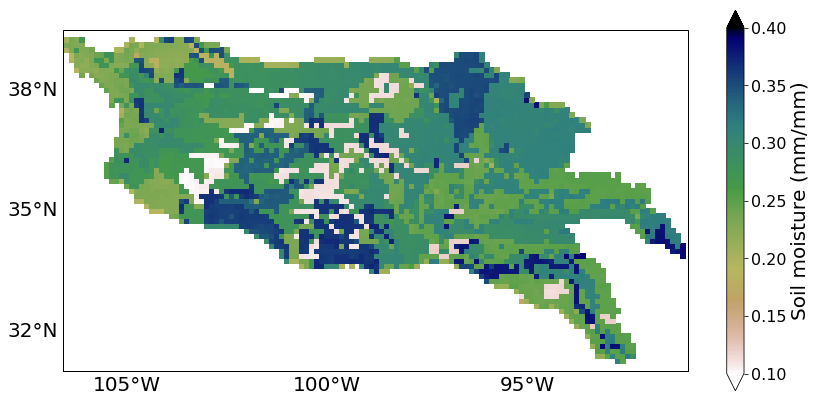

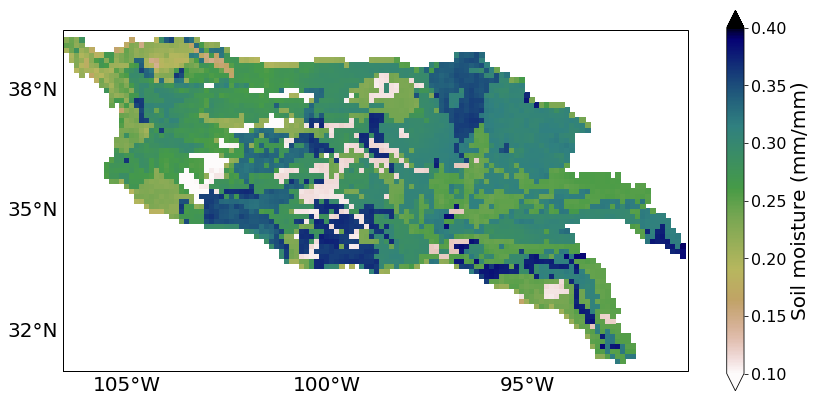

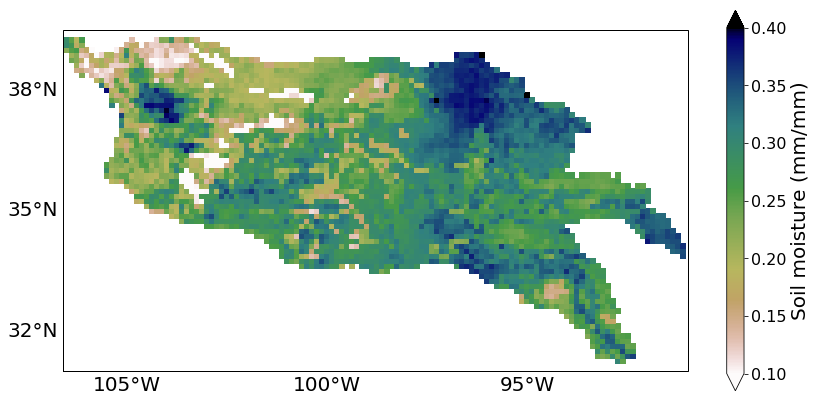

In [82]:
# --- Open-loop states --- #
# --- sm1 --- #
da_sm1_mean = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=0).mean(dim='time') / depth_sm1
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_sm1_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='gist_earth_r',
    vmin=0.1, vmax=0.4,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture (mm/mm)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'sm1.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- sm2 --- #
da_sm2_mean = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=1).mean(dim='time') / depth_sm2
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_sm2_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='gist_earth_r',
    vmin=0.1, vmax=0.4,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture (mm/mm)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'sm2.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- sm3 --- #
da_sm3_mean = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=2).mean(dim='time') / depth_sm3
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_sm3_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='gist_earth_r',
    vmin=0.1, vmax=0.4,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='both')
cbar.set_label('Soil moisture (mm/mm)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'sm3.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

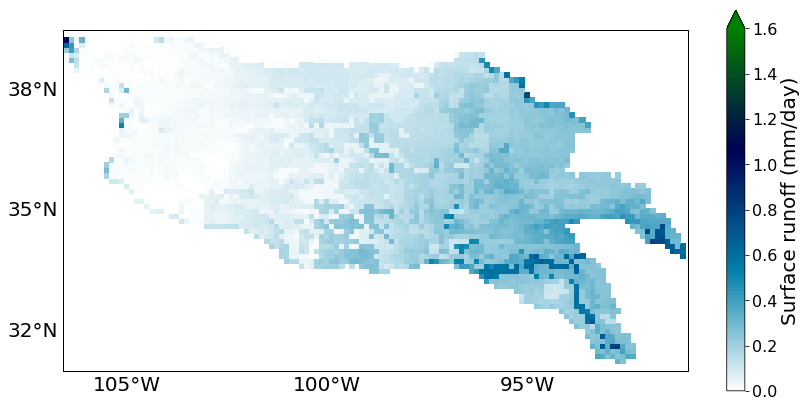

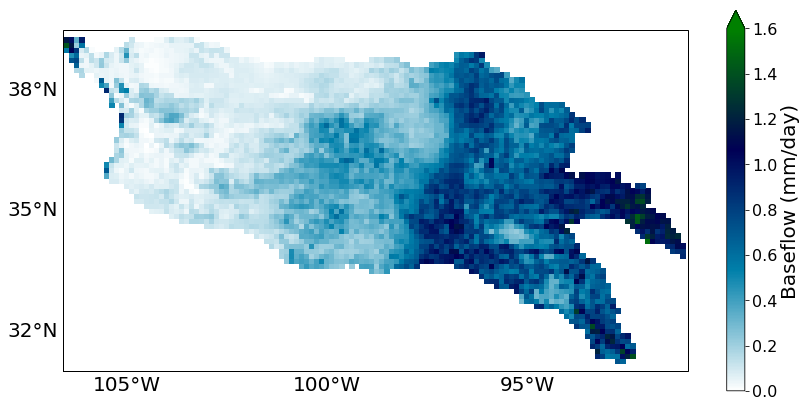

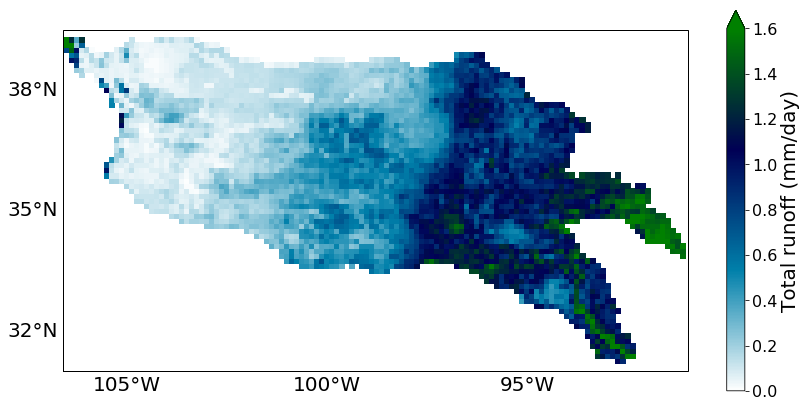

In [37]:
# --- Surface runoff --- #
out_nc = os.path.join(output_data_dir, 'openloop_dailyRunoff_mean.nc')
if not os.path.isfile(out_nc):
    da_dailyRunoff_mean = ds_openloop_hist['OUT_RUNOFF'].resample(
        '1D', dim='time', how='sum').mean(dim='time')
    ds_dailyRunoff_mean = xr.Dataset(
            {'runoff': da_dailyRunoff_mean})
    ds_dailyRunoff_mean.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    da_dailyRunoff_mean = xr.open_dataset(out_nc)['runoff']
    
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_dailyRunoff_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='ocean_r',
    vmin=0, vmax=1.6,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='max')
cbar.set_label('Surface runoff (mm/day)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'runoff.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- Baseflow --- #
out_nc = os.path.join(output_data_dir, 'openloop_dailyBaseflow_mean.nc')
if not os.path.isfile(out_nc):
    da_dailyBaseflow_mean = ds_openloop_hist['OUT_BASEFLOW'].resample(
        '1D', dim='time', how='sum').mean(dim='time')
    ds_dailyBaseflow_mean = xr.Dataset(
            {'baseflow': da_dailyBaseflow_mean})
    ds_dailyBaseflow_mean.to_netcdf(out_nc, format='NETCDF4_CLASSIC')
else:
    da_dailyBaseflow_mean = xr.open_dataset(out_nc)['baseflow']
    
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = da_dailyBaseflow_mean.where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='ocean_r',
    vmin=0, vmax=1.6,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='max')
cbar.set_label('Baseflow (mm/day)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'baseflow.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

# --- Total runoff --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = (da_dailyRunoff_mean + da_dailyBaseflow_mean).where(da_domain==1).plot.pcolormesh(
    'lon', 'lat', ax=ax,
    add_colorbar=False,
    add_labels=False,
    cmap='ocean_r',
    vmin=0, vmax=1.6,
    transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs, extend='max')
cbar.set_label('Total runoff (mm/day)', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'totrunoff.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

/usr/lusers/yixinmao/.conda/envs/vic5/lib/python3.5/site-packages/xarray/core/variable.py:1046: RuntimeWarning: invalid value encountered in true_divide
  if not reflexive


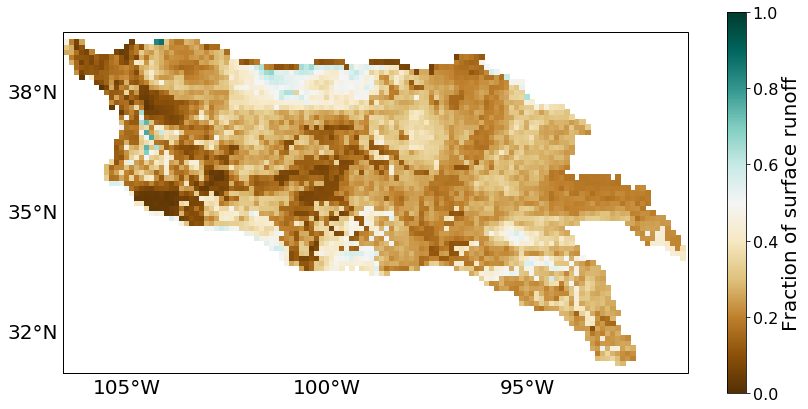

In [27]:
# --- Surface runoff fraction --- #
fig = plt.figure(figsize=(14, 7))
# Set projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-106.6, -91, 31, 39.5], ccrs.Geodetic())
gl = add_gridlines(ax, xlocs=[-95, -100, -105], ylocs=[32, 35, 38], alpha=0)
# Plot
cs = (da_dailyRunoff_mean / (da_dailyRunoff_mean + da_dailyBaseflow_mean)).where(
    da_domain==1).plot.pcolormesh(
        'lon', 'lat', ax=ax,
        add_colorbar=False,
        add_labels=False,
        cmap='BrBG',
        vmin=0, vmax=1,
        transform=ccrs.PlateCarree())
cbar = plt.colorbar(cs)
cbar.set_label('Fraction of surface runoff', fontsize=20)
plt.title("")
# Make plot looks better
for t in cbar.ax.get_yticklabels():
    t.set_fontsize(16)
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}
fig.savefig(os.path.join(output_maps_dir, 'runoff_frac.openloop.png'),
            format='png', bbox_inches='tight', pad_inches=0)

INFO:bokeh.core.state:Session output file './output/20170611.ArkRed.sm1_5.sm2_5.R_1.N32.Maurer_param.synthetic/time_series/34.9375_-96.6875.runoff.html' already exists, will be overwritten.


'/civil/hydro/ymao/data_assim/tools/plot_analyze_results/output/20170611.ArkRed.sm1_5.sm2_5.R_1.N32.Maurer_param.synthetic/time_series/34.9375_-96.6875.baseflow.html'

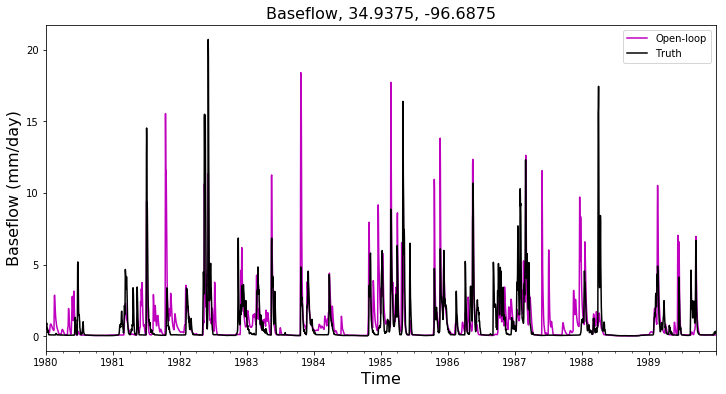

In [ ]:
# ======================================================== #
# Plot time series
# ======================================================== #
# === 31.1875, -92.6875 === #
lat = 34.9375
lon = -96.6875

# # --- sm1 --- #
# output_file(os.path.join(output_ts_dir, '{}_{}.sm1.html'.format(lat, lon)))
# p = figure(title='SM1, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot open-loop
# ts = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=0, lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=0, lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # plot measurement
# ts = da_meas.sel(lat=lat, lon=lon).to_series() / depth_sm1.sel(lat=lat, lon=lon).values
# p.circle(ts.index, ts.values, color="red", fill_color="red",
#          legend="Measurement", line_width=2)
# # Save
# save(p)

# # --- sm2 --- #
# fig = plt.figure(figsize=(12, 6))
# # plot open-loop
# ts_openloop = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# ts_openloop.plot(color='m', style='-',
#                  label='Open-loop',
#                  legend=True)
# # plot truth
# ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# ts_truth.plot(color='k', style='-',
#               label='Truth',
#               legend=True)
# # Make plot looks better
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Soil moiture (mm/mm)', fontsize=16)
# plt.title('SM2, {}, {}'.format(lat, lon), fontsize=16)
# # Save figure
# fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm2.png'.format(lat, lon)),
#             format='png')
# ### Interactive plot ###
# output_file(os.path.join(output_ts_dir, '{}_{}.sm2.html'.format(lat, lon)))
# p = figure(title='SM2, {}, {}'.format(lat, lon),
#            x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
#            x_axis_type='datetime', width=1000, height=500)
# # plot open-loop
# ts = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="magenta", line_dash="solid",
#        legend="Open-loop", line_width=2)
# # plot truth
# ts = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=1, lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# p.line(ts.index, ts.values, color="black", line_dash="solid",
#        legend="Truth", line_width=2)
# # plot measurement
# ts = da_meas.sel(lat=lat, lon=lon).to_series() / depth_sm2.sel(lat=lat, lon=lon).values
# p.circle(ts.index, ts.values, color="red", fill_color="red",
#          legend="Measurement", line_width=2)
# # Save
# save(p)

# # --- sm3 --- #
# fig = plt.figure(figsize=(12, 6))
# # plot open-loop
# ts_openloop = ds_openloop_states['SOIL_MOISTURE'].sel(
#     nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
# ts_openloop.plot(color='m', style='-',
#                  label='Open-loop',
#                  legend=True)
# # plot truth
# ts_truth = ds_truth_states['SOIL_MOISTURE'].sel(
#     nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
# ts_truth.plot(color='k', style='-',
#               label='Truth',
#               legend=True)
# # Make plot looks better
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Soil moiture (mm/mm)', fontsize=16)
# plt.title('SM3, {}, {}'.format(lat, lon), fontsize=16)
# # Save figure
# fig.savefig(os.path.join(output_ts_dir, '{}_{}.sm3.png'.format(lat, lon)),
#             format='png')
### Interactive plot ###
output_file(os.path.join(output_ts_dir, '{}_{}.sm3.html'.format(lat, lon)))
p = figure(title='SM3, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Soil moiture (mm/mm)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_states['SOIL_MOISTURE'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ds_truth_states['SOIL_MOISTURE'].sel(
    nlayer=2, lat=lat, lon=lon).to_series() / depth_sm3.sel(lat=lat, lon=lon).values
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# Save
save(p)

# --- Surface runoff --- #
output_file(os.path.join(output_ts_dir, '{}_{}.runoff.html'.format(lat, lon)))
p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Runoff (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ds_truth_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# Save
save(p)

# --- Baseflow --- #
fig = plt.figure(figsize=(12, 6))
# plot open-loop
ts_openloop = ds_openloop_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
    '1D', dim='time', how='sum').to_series()
ts_openloop.plot(color='m', style='-',
                 label='Open-loop',
                 legend=True)
# plot truth
ts_truth = ds_truth_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
    '1D', dim='time', how='sum').to_series()
ts_truth.plot(color='k', style='-',
              label='Truth',
              legend=True)
# Make plot looks better
plt.xlabel('Time', fontsize=16)
plt.ylabel('Baseflow (mm/day)', fontsize=16)
plt.title('Baseflow, {}, {}'.format(lat, lon), fontsize=16)
# Save figure
fig.savefig(os.path.join(output_ts_dir, '{}_{}.baseflow.png'.format(lat, lon)),
            format='png')
### Interactive ###
output_file(os.path.join(output_ts_dir, '{}_{}.baseflow.html'.format(lat, lon)))
p = figure(title='Baseflow, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Baseflow (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ts_openloop
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ts_truth
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# Save
save(p)

In [ ]:
# --- Surface runoff, perfect-all-state --- #
ts_truthStateOrigP_dailyRunoff = ds_truthStateOrigP_hist['OUT_RUNOFF'].sel(
    lat=lat, lon=lon).resample('1D', dim='time', how='sum').to_series()
output_file(os.path.join(output_ts_dir, '{}_{}.runoff_truthState.html'.format(lat, lon)))
p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Runoff (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ds_truth_hist['OUT_RUNOFF'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# plot perfect-all-state
ts = ts_truthStateOrigP_dailyRunoff
p.line(ts.index, ts.values, color="blue", line_dash="dashed",
       legend="Perfect-all-state", line_width=2)
# Save
save(p)

In [ ]:
# --- Baseflow, perfect-all-state --- #
ts_truthStateOrigP_dailyBASEFLOW = ds_truthStateOrigP_hist['OUT_BASEFLOW'].sel(
    lat=lat, lon=lon).resample('1D', dim='time', how='sum').to_series()
output_file(os.path.join(output_ts_dir, '{}_{}.baseflow_truthState.html'.format(lat, lon)))
p = figure(title='Surface runoff, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Baseflow (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ds_openloop_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ds_truth_hist['OUT_BASEFLOW'].sel(lat=lat, lon=lon).resample(
        '1D', dim='time', how='sum').to_series()
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# plot perfect-all-state
ts = ts_truthStateOrigP_dailyBaseflow
p.line(ts.index, ts.values, color="blue", line_dash="dashed",
       legend="Perfect-all-state", line_width=2)
# Save
save(p)

In [ ]:
# --- Precipitation forcing time series --- #
# --- Load data ---- #
# open-loop
start_year = start_time.year
end_year = end_time.year
list_ts_prec = []
for year in range(start_year, end_year+1):
    force_nc = '{}{}.nc'.format(orig_force_basepath, year)
    ts_prec = xr.open_dataset(force_nc)['PREC'].sel(lat=lat, lon=lon).to_series()
    list_ts_prec.append(ts_prec)
ts_openloop_prec = pd.concat(list_ts_prec, axis=0)

# truth
start_year = start_time.year
end_year = end_time.year
list_ts_prec = []
for year in range(start_year, end_year+1):
    force_nc = '{}{}.nc'.format(truth_force_basepath, year)
    ts_prec = xr.open_dataset(force_nc)['PREC'].sel(lat=lat, lon=lon).to_series()
    list_ts_prec.append(ts_prec)
ts_truth_prec = pd.concat(list_ts_prec, axis=0)

In [ ]:
# --- plot --- #
output_file(os.path.join(output_ts_dir, '{}_{}.prec_daily.html'.format(lat, lon)))
p = figure(title='Precipitation, {}, {}'.format(lat, lon),
           x_axis_label="Time", y_axis_label="Precipitation (mm/day)",
           x_axis_type='datetime', width=1000, height=500)
# plot open-loop
ts = ts_openloop_prec.resample('D', how='sum')
p.line(ts.index, ts.values, color="magenta", line_dash="solid",
       legend="Open-loop", line_width=2)
# plot truth
ts = ts_truth_prec.resample('D', how='sum')
p.line(ts.index, ts.values, color="black", line_dash="solid",
       legend="Truth", line_width=2)
# Save
save(p)

# Other

In [ ]:
lat = 31.1875
lon = -92.6875

In [ ]:
from analysis_utils import calculate_max_soil_moist_domain

In [ ]:
# --- Original parameters --- #
da_max_moist = calculate_max_soil_moist_domain(vic_global_txt).sel(lat=lat, lon=lon)
da_sm = ds_openloop_hist['OUT_SOIL_MOIST'].sel(lat=lat, lon=lon)
da_sm_sat = da_sm / da_max_moist

In [ ]:
# --- depth2_0.4 parameters --- #
vic_global_depth2_shallow = '/civil/hydro/ymao/data_assim/control/vic/' \
                            'hyak.test.31.1875_-92.6875.depth2_0.4.template.txt'
ds_openloop_hist_shallow_depth2 = xr.open_dataset(
    '/civil/hydro/ymao/data_assim/output/vic/' \
    'test.31.1875_-92.6875/openloop/depth2_0.4/' \
    'history/history.openloop.1980-01-01-00000.nc')

da_max_moist_depth2_shallow = calculate_max_soil_moist_domain(
    vic_global_depth2_shallow).sel(lat=lat, lon=lon)
da_sm_depth2_shallow = ds_openloop_hist_shallow_depth2['OUT_SOIL_MOIST'].sel(lat=lat, lon=lon)
da_sm_sat_depth2_shallow = da_sm_depth2_shallow / da_max_moist_depth2_shallow

In [ ]:
float(depth_sm2.sel(lat=lat, lon=lon).values)

In [ ]:
fig = plt.figure(figsize=(12, 6))
da_sm_sat.sel(nlayer=1).plot(color='black')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Soil moisture saturation', fontsize=16)
depth2 = float(depth_sm2.sel(lat=lat, lon=lon).values)
plt.title('SM2 (orig. Naoki\'s depth2 = {:.1f} mm), {}, {}'.format(
                depth2, lat, lon),
          fontsize=16)
fig.savefig('output/20170606.investigate_SM_control/{}_{}.sm2.naoki_param.png'.format(
                lat, lon),
            format='png')

In [ ]:
fig = plt.figure(figsize=(12, 6))
da_sm_sat_depth2_shallow.sel(nlayer=1).plot(color='black')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Soil moisture saturation', fontsize=16)
depth2 = float(depth_sm2.sel(lat=lat, lon=lon).values)
plt.title('SM2 (depth2 = 400 mm), {}, {}'.format(
                depth2, lat, lon),
          fontsize=16)
fig.savefig('output/20170606.investigate_SM_control/{}_{}.sm2.depth2_0.4.png'.format(
                lat, lon),
            format='png')

In [ ]:
ds_vic_param = xr.open_dataset(vic_param_nc)
ds_vic_param['depth'].sel(lat=lat, lon=lon)